In [1]:
%matplotlib inline

In [2]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
import shapely
import logging

import workflow
import workflow.source_list
import workflow.ui
import workflow.conf
import workflow.extrude
import workflow.rowcol


workflow.ui.setup_logging(1,None)


In [3]:
HUC = '060102020103'
crs = workflow.conf.default_crs()

logging.info("")
logging.info("Meshing HUC: {}".format(HUC))
logging.info("="*30)
logging.info('Target projection: "{}"'.format(crs['init']))
    

2019-07-11 17:20:26,509 - root - INFO: 
2019-07-11 17:20:26,511 - root - INFO: Meshing HUC: 060102020103
2019-07-11 17:20:26,512 - root - INFO: ==============================
2019-07-11 17:20:26,514 - root - INFO: Target projection: "epsg:5070"


In [4]:
sources = workflow.source_list.get_default_sources()
workflow.source_list.log_sources(sources)

2019-07-11 17:20:26,522 - root - INFO: Using sources:
2019-07-11 17:20:26,525 - root - INFO: --------------
2019-07-11 17:20:26,526 - root - INFO: HUC: National Watershed Boundary Dataset (WBD)
2019-07-11 17:20:26,528 - root - INFO: hydrography: National Hydrography Dataset (NHD)
2019-07-11 17:20:26,529 - root - INFO: DEM: National Elevation Dataset (NED)
2019-07-11 17:20:26,530 - root - INFO: soil type: National Resources Conservation Service Soil Survey (NRCS Soils)
2019-07-11 17:20:26,531 - root - INFO: land cover: None
2019-07-11 17:20:26,532 - root - INFO: soil thickness: None


In [5]:
# collect datasets
huc, centroid = workflow.get_split_form_hucs(sources['HUC'], HUC, crs=crs, centering=False)
rivers, centroid = workflow.get_rivers_by_bounds(sources['hydrography'], 
                                                 huc.exterior().bounds, crs, HUC, centering=centroid)

args = workflow.ui.default_simplify_options()
args.simplify=50
args.prune_reach_size=4
rivers = workflow.simplify_and_prune(huc, rivers, args)
    

2019-07-11 17:20:26,545 - root - INFO: 
2019-07-11 17:20:26,547 - root - INFO: Preprocessing HUC
2019-07-11 17:20:26,549 - root - INFO: ------------------------------
2019-07-11 17:20:26,551 - root - INFO: Loading level 12 HUCs in 060102020103.
2019-07-11 17:20:26,552 - root - INFO: Using HUC file "/Users/uec/research/water/data/meshing/examples/data/hydrography/WBD_06_GDB/WBD_06.gdb"
2019-07-11 17:20:27,050 - root - INFO: 
2019-07-11 17:20:27,051 - root - INFO: Preprocessing Hydrography
2019-07-11 17:20:27,051 - root - INFO: ------------------------------
2019-07-11 17:20:27,052 - root - INFO: loading streams in bounds (1129263.6900883, 1403956.5602751, 1147098.645102, 1414660.2215813)
2019-07-11 17:20:27,054 - root - INFO: Using Hydrography file "/Users/uec/research/water/data/meshing/examples/data/hydrography/NHD_H_06010202_GDB/NHD_H_06010202.gdb"
2019-07-11 17:20:27,559 - root - INFO: 
2019-07-11 17:20:27,560 - root - INFO: Simplifying and pruning
2019-07-11 17:20:27,563 - root - I

2019-07-11 17:20:28,288 - root - INFO: 
2019-07-11 17:20:28,289 - root - INFO: Meshing
2019-07-11 17:20:28,291 - root - INFO: ------------------------------
2019-07-11 17:20:28,301 - root - INFO: Triangulating...
2019-07-11 17:20:28,310 - root - INFO:    398 points and 400 facets
2019-07-11 17:20:28,312 - root - INFO:  checking graph consistency
2019-07-11 17:20:28,316 - root - INFO:  building graph data structures
2019-07-11 17:20:28,321 - root - INFO:  triangle.build...
2019-07-11 17:20:35,687 - root - INFO:   ...built: 6782 mesh points and 13212 triangles
2019-07-11 17:20:35,688 - root - INFO: Plotting triangulation diagnostics
2019-07-11 17:20:37,087 - root - INFO: 
2019-07-11 17:20:37,087 - root - INFO: Preprocessing Raster
2019-07-11 17:20:37,088 - root - INFO: ------------------------------
2019-07-11 17:20:37,089 - root - INFO: downloading raster
2019-07-11 17:20:37,091 - root - INFO: Collecting DEMs to tile bounds: (-83.47869992669801, 35.02035285918288, -83.28113437388001, 35

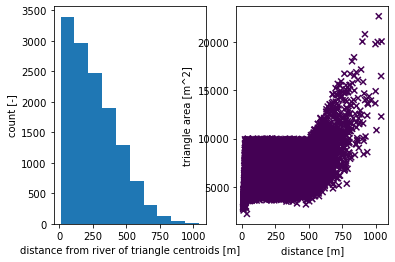

In [6]:
args = workflow.ui.default_triangulate_options()
args.delaunay = False

# triangulation options:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the distance from the triangle
# centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and linearly interpolates
# between the two endpoints.
d0 = 500; d1 = 2000
A0 = 10000; A1 = 50000
args.refine_distance = [d0,A0,d1,A1]

# make 2D mesh
mesh_points2, mesh_tris = workflow.triangulate(huc, rivers, args, diagnostics=True)

# get a raster for the elevation map
dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], huc.polygon(0), crs)

# elevate the triangle nodes to the dem
mesh_points3 = workflow.elevate(mesh_points2, crs, dem, dem_profile)

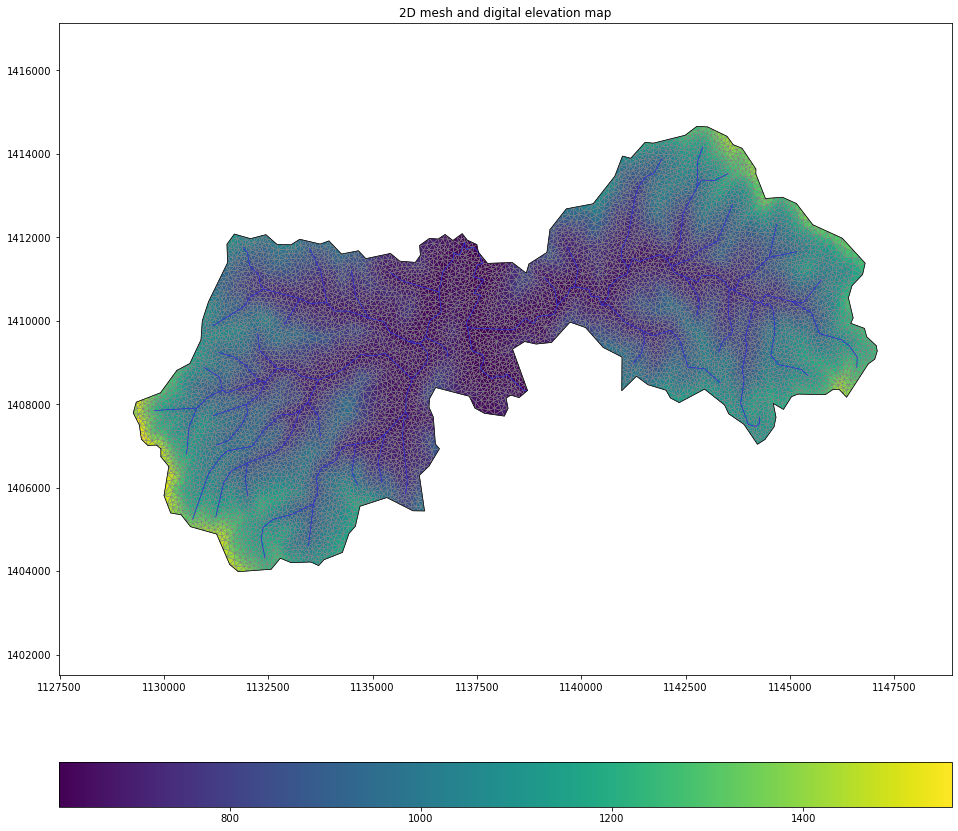

In [7]:
# plot the resulting surface mesh
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, linewidth=0.5, color='elevation')
fig.colorbar(mp, orientation="horizontal", pad=0.1)
workflow.plot.hucs(huc, 'k', linewidth=0.7)
workflow.plot.rivers(rivers, color='blue', linewidth=0.5)
ax.set_aspect('equal', 'datalim')
t = ax.set_title('2D mesh and digital elevation map')

In [8]:
# convert the triangulation into a 2D mesh for extrusion
m2 = workflow.extrude.Mesh2D(mesh_points3, list(mesh_tris))

In [9]:
# download the NRCS soils data as shapes and convert it to raster
import workflow.sources.manager_nrcs
import matplotlib.cm

# -- download the shapes
target_bounds = huc.exterior().bounds
soil_survey, soil_ids, centroid = workflow.get_shapes_in_bounds(sources['soil type'], huc.exterior().bounds, crs)
soil_ids = np.array(soil_ids, np.int32)

target_filename = os.path.join(workflow.conf.rcParams['data dir'], 'soil_survey', 
                       'soil_survey_W{0:.0g}_N{3:.0g}.tif')

# -- create a map from sane IDs to map unit ids from NRCS
#soil_indices = dict((1001+i, v) for (i,v) in enumerate(soil_properties))
#soil_ids_new = range(1001,1001+len(soil_ids))

# -- color a raster by the polygons (this makes identifying a triangle's value much more efficient)
soil_color, soil_profile, img_bounds = workflow.color_raster_from_shapes(target_bounds, 10, target_filename, 
                                                                soil_survey, soil_ids, crs)

geologic_type = 101 * np.ones((len(mesh_tris),),'i')

2019-07-11 17:20:38,882 - root - INFO: 
2019-07-11 17:20:38,884 - root - INFO: Preprocessing Shapes
2019-07-11 17:20:38,885 - root - INFO: ------------------------------
2019-07-11 17:20:38,887 - root - INFO:   Using filename: /Users/uec/research/water/data/meshing/examples/data/soil_survey/soil_survey_shape_-83.4843_35.0031_-83.2731_35.1189.gml
2019-07-11 17:20:40,051 - root - INFO:   Found 4392 shapes.
2019-07-11 17:20:47,930 - root - INFO:   With bounds: (-83.509058, 34.993085, -83.230402, 35.299246)
2019-07-11 17:20:48,572 - root - INFO: Coloring shapes onto raster: "/Users/uec/research/water/data/meshing/examples/data/soil_survey/soil_survey_W{0:.0g}_N{3:.0g}.tif"
2019-07-11 17:20:48,572 - root - INFO:   target_bounds = (1129263.6900883, 1403987.368097, 1147094.9805085, 1414660.2215813)
2019-07-11 17:20:48,573 - root - INFO:   img_bounds = [1129259.0, 1403985.0, 1147109.0, 1414665.0]
2019-07-11 17:20:48,574 - root - INFO:   pixel_size = 10
2019-07-11 17:20:48,575 - root - INFO:   

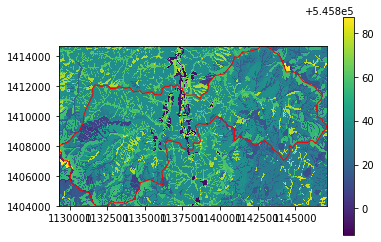

In [10]:
# plot the soil survey
extent = [img_bounds[0], img_bounds[2], img_bounds[1], img_bounds[3]]

soil_color = np.where(soil_color == -1, np.nan, soil_color)
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='white')

vmax = max(soil_ids)
vmin = min(soil_ids)
plt.imshow(soil_color, vmax=vmax, vmin=vmin, extent=extent)
plt.colorbar()

workflow.plot.hucs(huc, color='r')

plt.show()

/Users/uec/research/water/data/meshing/workflow/plot.py:78: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if color == 'elevation' and points.shape[1] != 3:
/Users/uec/research/water/data/meshing/workflow/plot.py:81: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if color == 'elevation':


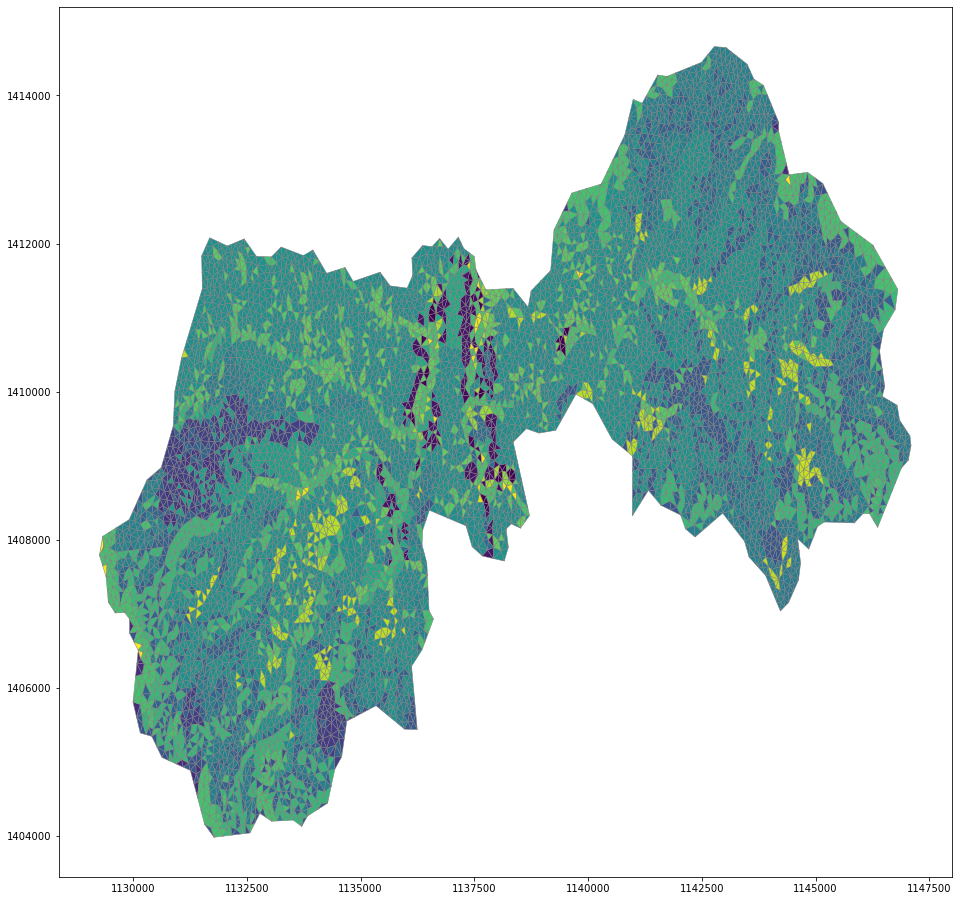

In [11]:
# pick the soil type for triangle centroids
tri_centroids = m2.centroids()
tri_soil_ids = soil_color[workflow.rowcol.rowcol(soil_profile['transform'], tri_centroids[:,0], tri_centroids[:,1])]

soil_labels = dict()
soil_label_counter = 1001

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, linewidth=0.5, color=tri_soil_ids)
plt.show()

In [12]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []
z = 0.0

# -- soil layer --
#  top 6 m
#  5 cm initial top cell
#  10 cells
#  expanding dz, growing with depth
ncells = 9
dz = 0.05
layer_dz = 4

def telescope_factor(ncells, dz, layer_dz):
    """Calculates a telescoping factor"""
    if ncells * dz > layer_dz:
        raise ValueError(("Cannot telescope {} cells of thickness at least {} "+
                          "and reach a layer of thickness {}").format(ncells, dz, layer_dz))

    import scipy.optimize
    def seq(r):
        calc_layer_dz = dz * (1 - r**ncells)/(1-r)
        #print('tried: {} got: {}'.format(r, calc_layer_dz))
        return layer_dz - calc_layer_dz
    res = scipy.optimize.root_scalar(seq, x0=1.0001, x1=2)
    return res.root

tele = telescope_factor(ncells, dz, layer_dz)
logging.info("Got telescoping factor: {}".format(tele))
for i in range(ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(tri_soil_ids)
    z += dz
    dz *= tele
    
# one more 2m layer makes 6m
dz = 2.0
layer_types.append('constant')
layer_data.append(dz)
layer_ncells.append(1)
layer_mat_ids.append(tri_soil_ids)
z += dz

# -- geologic layer --
# keep going for 2m cells until we hit the bottom of
# the domain
layer_types.append("constant")
layer_data.append(40 - z) # depth of bottom of domain is 40 m
layer_ncells.append(int(round(layer_data[-1] / dz)))
layer_mat_ids.append(geologic_type)

# print the summary
workflow.extrude.Mesh3D.summarize_extrusion(layer_types, layer_data, layer_ncells, layer_mat_ids)

2019-07-11 17:20:58,411 - root - INFO: Got telescoping factor: 1.515910144611108
2019-07-11 17:20:58,413 - root - INFO: Cell summary:
2019-07-11 17:20:58,413 - root - INFO: ------------------------------------------------------------
2019-07-11 17:20:58,414 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2019-07-11 17:20:58,415 - root - INFO: ------------------------------------------------------------
2019-07-11 17:20:58,417 - root - INFO:  00 	| 00 	| 545854 	|   0.050000 	|   0.000000
2019-07-11 17:20:58,418 - root - INFO:  01 	| 01 	| 545854 	|   0.075796 	|   0.050000
2019-07-11 17:20:58,419 - root - INFO:  02 	| 02 	| 545854 	|   0.114899 	|   0.125796
2019-07-11 17:20:58,420 - root - INFO:  03 	| 03 	| 545854 	|   0.174177 	|   0.240695
2019-07-11 17:20:58,421 - root - INFO:  04 	| 04 	| 545854 	|   0.264036 	|   0.414872
2019-07-11 17:20:58,421 - root - INFO:  05 	| 05 	| 545854 	|   0.400255 	|   0.678908
2019-07-11 17:20:58,422 - root - INFO:  06 	| 06 	| 545854 	|   0.60675

In [13]:
# extrude
m3 = workflow.extrude.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, layer_ncells, layer_mat_ids)

In [14]:
# save to disk
m3.write_exodus('mesh_{}.exo'.format(HUC))


You are using exodus.py v 1.12 (seacas-beta), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: mesh_060102020103.exo


Exception: ERROR: Cowardly not opening mesh_060102020103.exo for write. File already exists.

In [ ]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []
z = 0.0

# -- soil layer --
#  top 6 m
#  5 cm initial top cell
#  10 cells
#  expanding dz, growing with depth
ncells = 9
dz = 0.05
layer_dz = 4

def telescope_factor(ncells, dz, layer_dz):
    """Calculates a telescoping factor"""
    if ncells * dz > layer_dz:
        raise ValueError(("Cannot telescope {} cells of thickness at least {} "+
                          "and reach a layer of thickness {}").format(ncells, dz, layer_dz))

    import scipy.optimize
    def seq(r):
        calc_layer_dz = dz * (1 - r**ncells)/(1-r)
        #print('tried: {} got: {}'.format(r, calc_layer_dz))
        return layer_dz - calc_layer_dz
    res = scipy.optimize.root_scalar(seq, x0=1.0001, x1=2)
    return res.root

tele = telescope_factor(ncells, dz, layer_dz)
logging.info("Got telescoping factor: {}".format(tele))
for i in range(ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(tri_soil_ids)
    z += dz
    dz *= tele
    
# one more 2m layer makes 6m
dz = 2.0
layer_types.append('constant')
layer_data.append(dz)
layer_ncells.append(1)
layer_mat_ids.append(tri_soil_ids)
z += dz

# -- geologic layer --
# keep going for 2m cells until we hit the bottom of
# the domain
layer_types.append("constant")
layer_data.append(40 - z) # depth of bottom of domain is 40 m
layer_ncells.append(int(round(layer_data[-1] / dz)))
layer_mat_ids.append(geologic_type)

# print the summary
workflow.extrude.Mesh3D.summarize_extrusion(layer_types, layer_data, layer_ncells, layer_mat_ids)